## Logistic reg

In [110]:
import numpy as np

np.random.seed(0)

w = np.array([ 1.1531374 ,  1.52393116, -0.11645899, -0.87396687,
               0.09122844, -0.18461272,  0.3417083 , -0.35062283,
               -0.08556754, -0.04894171, 0.01885449,  0.01844559,
               -0.00215485,  0.02230771, -0.02698094, -0.00534462
            ])
b = -0.6557785371575575

In [111]:
import pandas as pd

df = pd.read_csv("possessions_with_rolling_stats.csv")
df[["Steal"]] = df.groupby(["GameID"]).shift(1)[["Steal"]]
df.dropna(inplace=True)

train_size = int(len(df) * 0.8)

feats = [
        'Offensive_rebound', 'Defensive_rebound', 'Steal', 'Block',
        'OffPPM', 'DefPPM', 'OffAPM', 'OffRPM', 'DefAPM', 'DefRPM',
        'OffRaptorOff', 'OffRaptorDef', 'OffRaptorWar',
        'DefRaptorOff', 'DefRaptorDef', 'DefRaptorWar',
        ]
X = df.iloc[train_size:][feats].to_numpy().astype(float)
y = (df.iloc[train_size:]["Points"].to_numpy() > 0).astype(int)

# Drop all-zero rows
# df = df[(df[["Offensive_rebound", "Defensive_rebound", "Steal", "Block"]] != 0).any(axis=1)]

y_pred = 1 / (1 + np.exp(-np.dot(X, w) - b))
print(y_pred.min(), y_pred.max())

0.08628763501296707 0.9979540254707017


In [112]:
roc_scores = []

for cutoff in np.linspace(0, 1, 101):
    y_out = (y_pred > cutoff).astype(int)

    tp = ((y == 1) & (y_out == 1)).sum() / len(y == 1)
    fp = ((y == 0) & (y_out == 1)).sum() / len(y == 0)

    roc_scores.append((cutoff, tp, fp))

len(roc_scores)

101

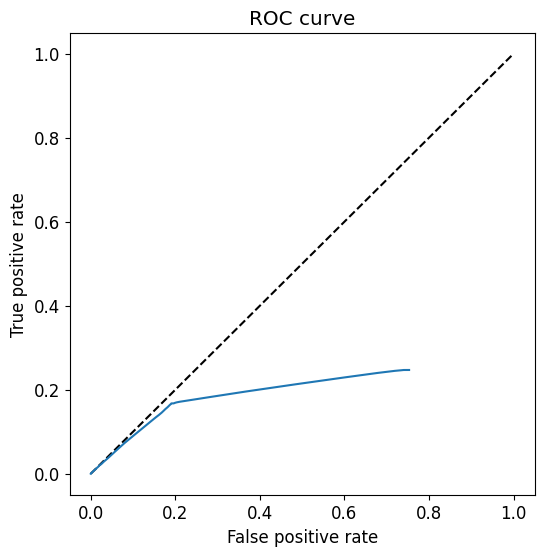

In [113]:
# Plot ROC curve

import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], linestyle="--", color="black")

plt.plot([x[2] for x in roc_scores], [x[1] for x in roc_scores])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")

plt.savefig("roc_curve.png")


In [114]:
# Compute AUROC

# Sort by false positive rate
roc_scores = sorted(roc_scores, key=lambda x: x[2])

auroc = 0

for i in range(len(roc_scores) - 1):
    auroc += (roc_scores[i + 1][2] - roc_scores[i][2]) * (roc_scores[i + 1][1] + roc_scores[i][1]) / 2

print("AUROC:", auroc)

AUROC: 0.13438166493046955


In [92]:
(y_out[y==0] == y[y==0]).sum() / len(y[y==0])

1.0

In [115]:
# Optimal cutoff

opt_cutoff = max(roc_scores, key=lambda x: x[1] - x[2])
print("Optimal cutoff:", opt_cutoff[0])
print("TP rate: {}; FP rate: {}".format(opt_cutoff[1], opt_cutoff[2]))

# Accuracy with optimal cutoff
y_out = (y_pred > opt_cutoff[0]).astype(int)
print(f"Accuracy: {(y_out == y).sum() / len(y)}")


Optimal cutoff: 0.84
TP rate: 0.004035622456451036; FP rate: 0.0036780356565123368
Accuracy: 0.7533502477565686


True positive rate: 0.19158948617571236
True negative rate: 0.9308198210866767
False positive rate: 0.06918017891332331
False negative rate: 0.8084105138242876


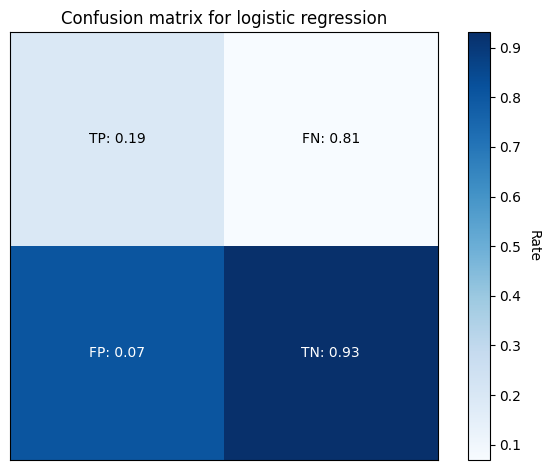

In [59]:
tp_rate = np.mean(y[y == 1] == y_pred[y == 1])
tn_rate = np.mean(y[y == 0] == y_pred[y == 0])
fp_rate = np.mean(y[y == 0] != y_pred[y == 0])
fn_rate = np.mean(y[y == 1] != y_pred[y == 1])

print(f"True positive rate: {tp_rate}")
print(f"True negative rate: {tn_rate}")
print(f"False positive rate: {fp_rate}")
print(f"False negative rate: {fn_rate}")

# Plot confusion matrix
import matplotlib.pyplot as plt

confusion_matrix = np.zeros((2, 2))
confusion_matrix[0, 0] = tp_rate
confusion_matrix[0, 1] = fp_rate
confusion_matrix[1, 0] = fn_rate
confusion_matrix[1, 1] = tn_rate

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap="Blues")

# Legend
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Rate", rotation=-90, va="bottom")

# Hide axes
ax.set_xticks(np.arange(0))
ax.set_yticks(np.arange(0))

# Label squares
ax.text(
    0, 0, f"TP: {confusion_matrix[0, 0]:.2f}",
    ha="center",
    va="center",
    color="black",
)
ax.text(
    0, 1, f"FP: {confusion_matrix[0, 1]:.2f}",
    ha="center",
    va="center",
    color="w",
)
ax.text(
    1, 0, f"FN: {confusion_matrix[1, 0]:.2f}",
    ha="center",
    va="center",
    color="black",
)
ax.text(
    1, 1, f"TN: {confusion_matrix[1, 1]:.2f}",
    ha="center",
    va="center",
    color="w",
)

# Set title
ax.set_title("Confusion matrix for logistic regression")

# Save as png
fig.tight_layout()
fig.savefig("confusion_matrix.png", dpi=300)


In [105]:
def predict(w, b, X):
    return 1 / (1 + np.exp(-np.dot(X, w) - b))

avgs = df[feats].mean().to_numpy()
input_mat = np.eye(len(feats))
input_mat[:, 4:] = avgs[4:]

pred_probs = predict(w, b, input_mat)[:4]

In [106]:
pred_probs

array([0.32644659, 0.42386439, 0.12807247, 0.05060206])

In [107]:
true_probs = [(df[df[feat] == 1]['Points'] > 0).mean() for feat in ['Offensive_rebound', 'Defensive_rebound', 'Steal', 'Block']]

In [108]:
true_probs

[0.4623019919777007,
 0.45066433566433567,
 0.1503060530491952,
 0.17348803215786587]

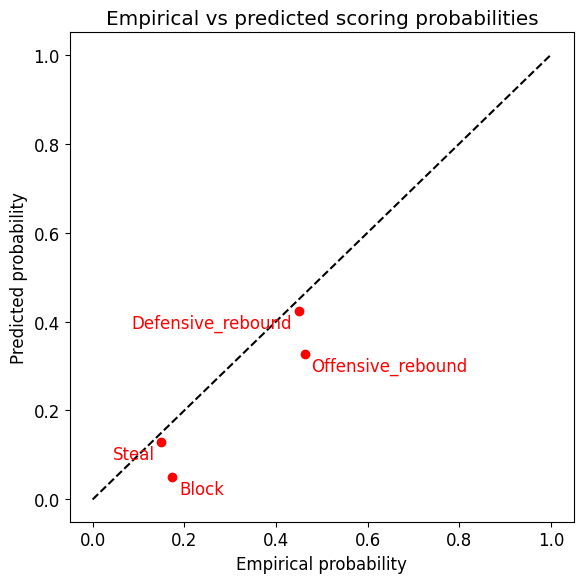

In [109]:
# Plot true vs predicted probabilities

fig, ax = plt.subplots()

ax.scatter(true_probs, pred_probs, color="red")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")

ax.set_xlabel("Empirical probability")
ax.set_ylabel("Predicted probability")

# Label points
for i, feat in enumerate(feats[:4]):
    ax.annotate(
        feat,
        (true_probs[i], pred_probs[i]),
        textcoords="offset points",
        xytext=(5, -12) if feat in ["Offensive_rebound", "Block"] else (-5, -12),
        ha="left" if feat in ["Offensive_rebound", "Block"] else "right",
        color="red"
    )

# Add a horizontal line and label it
# avg_possession = (df["Points"] > 0).mean()
# ax.axhline(avg_possession, color="blue", linestyle="--")
# ax.annotate(
#     "Average possession",
#     (0, avg_possession),
#     textcoords="offset points",
#     xytext=(0, 10),
#     ha="left",
#     color="blue",
# )

plt.title("Empirical vs predicted scoring probabilities")

fig.tight_layout()
fig.savefig("true_vs_predicted.png", dpi=300)

## Linear reg

In [47]:
w = np.array([0.37078835,  0.683867  , -0.01499103, -0.32244272,
              0.05396289,  0.00461407, -0.00787341,  0.01045856,
              0.02399101, -0.00770514, 0.00321273,  0.00128748,
              0.00162389,  0.0011181 , -0.00644823, -0.00196369
            ])
b = 0.09278989990483029

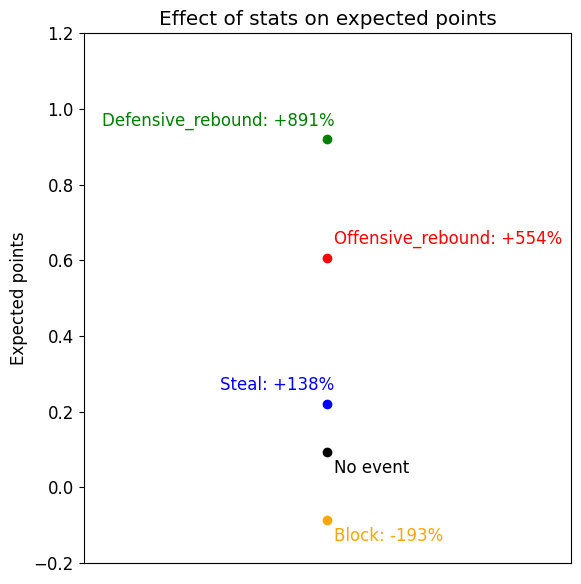

In [68]:
# Plot y = wx + b, labeled by feature

fig, ax = plt.subplots()

# Change plot size
plt.rcParams["figure.figsize"] = (6, 6)

# Set font size
plt.rcParams["font.size"] = 12

colors = ["red", "green", "blue", "orange"]
ax.scatter(0, b, label="No stats", color="black")
ax.annotate(
    f"No event",
    (0, b),
    textcoords="offset points",
    xytext=(5, -15),
    ha="left",
)
for i, (feat, color) in enumerate(zip(feats, colors)):
    x = 1
    y = np.dot(w, input_mat[i]) + b
    ax.scatter(0, y, label=feat, color=color)

    # Add percent change from no stats
    pct_change = (y - b) / b
    ax.annotate(
        f"{feat}: {pct_change:+.0%}",
        (0, y),
        textcoords="offset points",
        xytext=(5, -15) if feat in ["Block"] else (5, 10),
        ha="left" if feat in ["Offensive_rebound", "Block"] else "right",
        color=color
    )

# Set axes
ax.set_ylim(-0.2, 1.2)

# Remove x axis
ax.set_xticks(np.arange(0))
ax.set_xticklabels([])

# Set y axis
ax.set_ylabel("Expected points")

plt.title("Effect of stats on expected points")


# Save
fig.tight_layout()
fig.savefig("stat_values.png", dpi=300)


<BarContainer object of 5 artists>

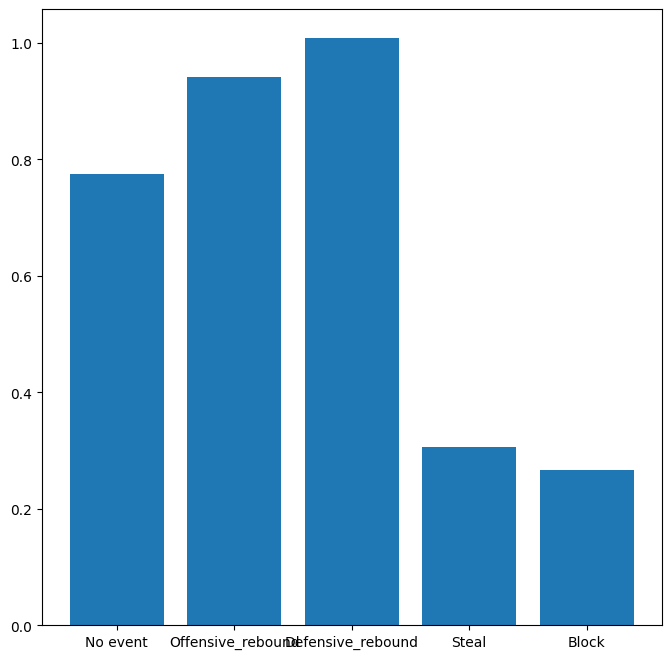

In [127]:
# Plot y = wx + b

fig, ax = plt.subplots()

plt.bar(["No event"] + feats, [b] + [wi + b for wi in w])